# 1. Perkenalan

Nama : Adnan Rio

Batch : FTDS-014

Dataset : census_adult_income

## Objective : 

Mengevaluasi konsep Logistic Regression dan SVM sebagai berikut:

-   Mampu memperoleh data menggunakan BigQuery
-   Mampu memahami konsep Classification dengan Logistic Regression dan SVM
-   Mampu mempersiapkan data untuk digunakan dalam model Logistic Regression dan SVM
-   Mampu mengimplementasikan Logistic Regression dan SVM untuk membuat prediksi

### 1.a SQL Querry:

SELECT age, 
workclass, 
education, 
education_num, 
marital_status, 
occupation, 
relationship, 
race, 
sex, 
capital_gain, 
capital_loss, 
hours_per_week, 
native_country, 
income_bracket FROM bigquery-public-data.ml_datasets.census_adult_income 
WHERE workclass != ' ?' 
AND hours_per_week <= 100 
LIMIT 27902;

---
#   2. Import Libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

---
# 3. Data Loading
Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll

In [76]:
data = pd.read_csv('h8dsft_P1G2_adnan_rio.csv', skipinitialspace=True)
df = data.copy() #copy df untuk menjaga data RAW 
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


In [77]:
df.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
27897,45,Federal-gov,Assoc-acdm,12,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,<=50K
27898,38,Private,Assoc-acdm,12,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
27899,39,Local-gov,Assoc-acdm,12,Never-married,Transport-moving,Not-in-family,White,Male,0,0,48,United-States,<=50K
27900,25,Private,Assoc-acdm,12,Never-married,Tech-support,Not-in-family,White,Male,0,0,30,United-States,<=50K
27901,27,Private,Assoc-acdm,12,Never-married,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K


Data loading, sebelumnya dilakukan explore pada file csv. Data tersebut ditambahkan skipinitialspace=True untuk menghapus empty space. Untuk mencegah kebingungan saat filtering atau grouping data empty space di setiap kolom yang bertipe string

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27902 entries, 0 to 27901
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27902 non-null  int64 
 1   workclass       27902 non-null  object
 2   education       27902 non-null  object
 3   education_num   27902 non-null  int64 
 4   marital_status  27902 non-null  object
 5   occupation      27902 non-null  object
 6   relationship    27902 non-null  object
 7   race            27902 non-null  object
 8   sex             27902 non-null  object
 9   capital_gain    27902 non-null  int64 
 10  capital_loss    27902 non-null  int64 
 11  hours_per_week  27902 non-null  int64 
 12  native_country  27902 non-null  object
 13  income_bracket  27902 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.0+ MB


In [79]:
df.describe() # melihat persebaran data df, dan mengetahui masing-masing kolom di dalam df

,age,education_num,capital_gain,capital_loss,hours_per_week
count,27902.000000,27902.000000,27902.000000,27902.000000,27902.000000
mean,38.736148,10.155795,1163.901512,91.394452,41.107734
std,13.045505,2.612946,7718.506324,410.372986,12.015429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Untuk melihat central tendency dari dataset.

Info diatas berisi tipe data dari semua kolom, dan bisa disimpulkan kalau tidak ada nilai Null pada data.

---
# 4. Exploratory Data Analysis (EDA)

> Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, heatmap, central tendency dan lain sebagainya.

c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Capital Loss')

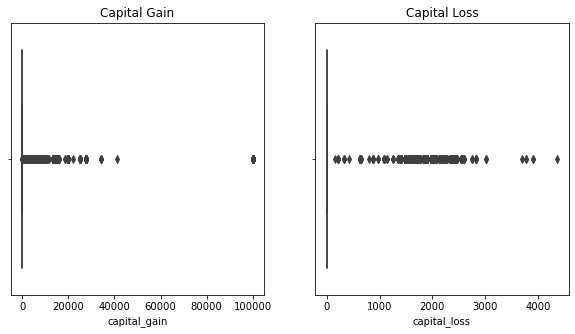

In [80]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(df['capital_gain'])
plt.title('Capital Gain')

fig.add_subplot(row, col, 2)
sns.boxplot(df['capital_loss'])
plt.title('Capital Loss')

Pada kolom capital_gain dan capital_loss banyak nilai 0, saya berasumsi informasi yang harus disi belum lengkap maka akan saya drop kolom

In [81]:
df.groupby(df['occupation'])['hours_per_week'].sum().sort_values(ascending=False)

occupation
Exec-managerial      170479
Prof-specialty       163878
Craft-repair         160535
Sales                136067
Adm-clerical         121870
Other-service         99100
Machine-op-inspct     75152
Transport-moving      67544
Handlers-cleaners     45772
Farming-fishing       44154
Tech-support          32222
Protective-serv       25873
Priv-house-serv        3925
Armed-Forces            218
?                       199
Name: hours_per_week, dtype: int64

Setalah groupby persebaran data Jumlah jam kerja untuk setiap pekerjaan setiap minggu

<AxesSubplot:xlabel='education_num,education'>

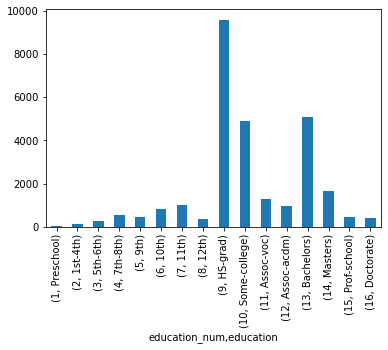

In [82]:
plotcek = df.groupby(df['education_num'])['education'].value_counts().sort_index()
plotcek.plot(kind='bar')

Plotbar groupby persebaran data untuk kategori education adalah 9 HS Grade

In [83]:
df.groupby(df['education_num'])['education'].value_counts().sort_index()

education_num  education   
1              Preschool         42
2              1st-4th          140
3              5th-6th          263
4              7th-8th          543
5              9th              434
6              10th             796
7              11th            1005
8              12th             374
9              HS-grad         9602
10             Some-college    4879
11             Assoc-voc       1297
12             Assoc-acdm       935
13             Bachelors       5097
14             Masters         1665
15             Prof-school      435
16             Doctorate        395
Name: education, dtype: int64

Pada groupby diatas korelasi kolom education merupakan definisi dari education_num, untuk pengolahan agar optimal nantinya salah satu akan didrop.

In [84]:
plot1=df.groupby(df['education_num'])['income_bracket'].value_counts().reset_index(name='count')
plot2=df.groupby(df['sex'])['income_bracket'].value_counts().reset_index(name='count')
plot2.head()

,sex,income_bracket,count
0,Female,<=50K,7562
1,Female,>50K,1058
2,Male,<=50K,12914
3,Male,>50K,6368


<AxesSubplot:xlabel='sex', ylabel='count'>

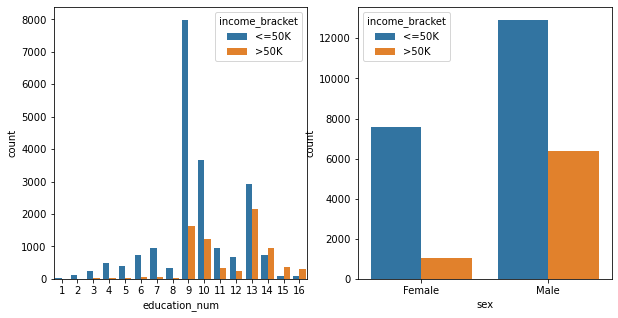

In [85]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.barplot(data=plot1,x='education_num',y='count',hue='income_bracket')

fig.add_subplot(row, col, 2)
sns.barplot(data=plot2,x='sex',y='count',hue='income_bracket')


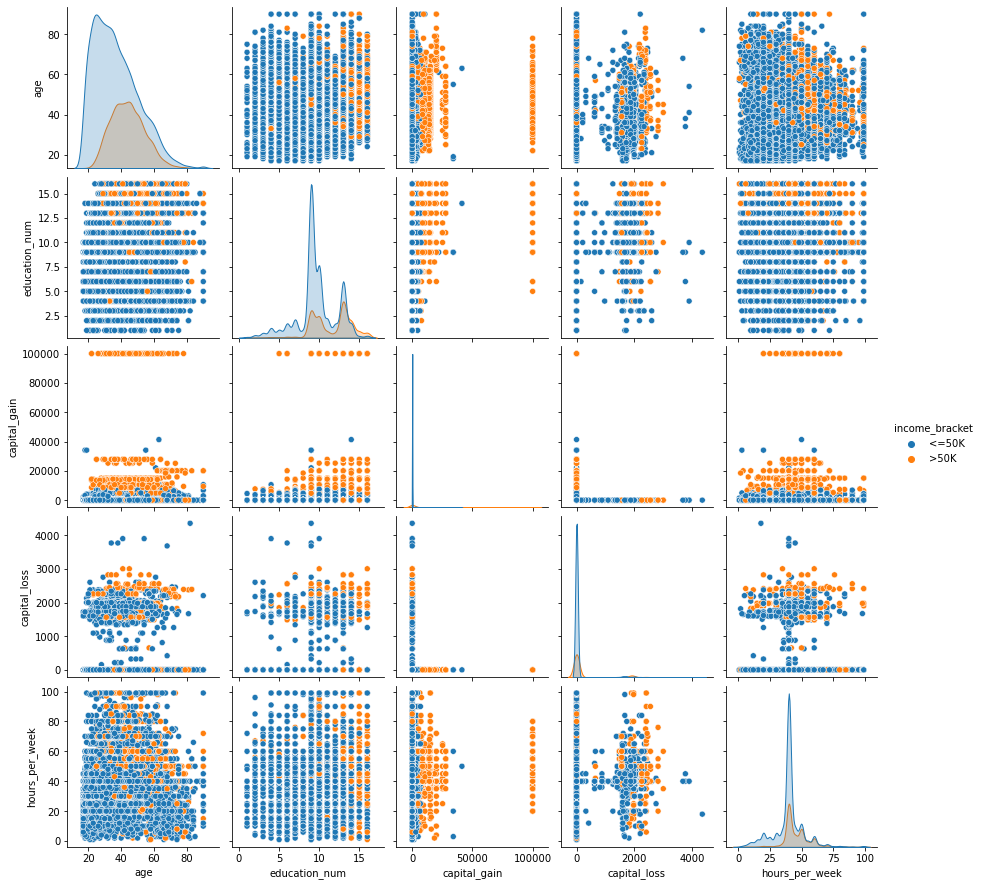

In [86]:
sns.pairplot(df,hue='income_bracket')

Setelah melihat dari berbagai macam plot dari setiap kolom dapat disimpulkan persebaran data banyak yang overlap tidak teralu berkorelasi

<AxesSubplot:>

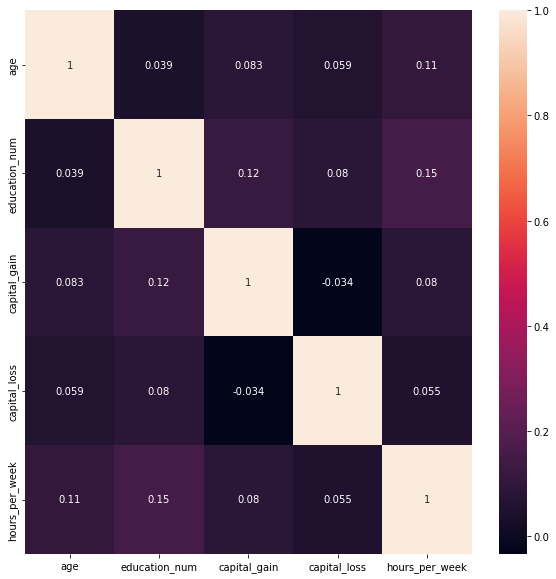

In [87]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

Pada heatmap, kolom numerik pada data ini cenderung tidak berkorelasi sesuai dengan nilai korelasi yang dihasilkan yang mana jauh dari angka 1.

---
# 5. Data Preprocessing

> Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

In [88]:
df.head()  # Sebelum drop 3 colom 'capital_gain','capital_loss','education'

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K


In [89]:
df.drop(columns=['capital_gain','capital_loss','education'],inplace=True)

Pada 3 kolom tersebut akan di drop setelah melihat hasil EDA

In [90]:
df.head() # Setelah drop 3 colom 'capital_gain','capital_loss','education'

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States,<=50K
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States,>50K
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States,>50K
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States,<=50K


Tampilan data setelah ada 3 kolom yang di drop.

## Get Data for Model Inference

In [91]:
# get data for model inference
df_inf = df.sample(10, random_state=95)
df_inf

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
19833,43,Private,9,Separated,Handlers-cleaners,Unmarried,Black,Female,45,United-States,<=50K
5323,54,Private,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,<=50K
20827,38,Private,13,Divorced,Prof-specialty,Unmarried,White,Female,56,United-States,<=50K
1368,36,Private,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,35,United-States,>50K
14385,18,Private,6,Never-married,Machine-op-inspct,Own-child,White,Male,40,United-States,<=50K
6632,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,45,United-States,<=50K
4222,46,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
3254,55,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,60,United-States,<=50K
21802,39,Private,10,Married-spouse-absent,Craft-repair,Unmarried,White,Male,40,United-States,>50K
21888,44,Private,10,Divorced,Adm-clerical,Unmarried,White,Female,57,United-States,<=50K


In [92]:
# Reset index dari kedua dataframe inference dan data untuk train & test
df_train_test = df.drop(df_inf.index)
df_train_test

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States,<=50K
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States,>50K
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States,>50K
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
27897,45,Federal-gov,12,Never-married,Exec-managerial,Not-in-family,White,Male,40,United-States,<=50K
27898,38,Private,12,Never-married,Craft-repair,Not-in-family,White,Male,40,United-States,<=50K
27899,39,Local-gov,12,Never-married,Transport-moving,Not-in-family,White,Male,48,United-States,<=50K
27900,25,Private,12,Never-married,Tech-support,Not-in-family,White,Male,30,United-States,<=50K


Data inference disimpan dalam variabel df_train_test

In [93]:
# reset index
df_train_test.reset_index(drop=True, inplace=True)
df_inf.reset_index(drop=True, inplace=True)
df_inf

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket
0,43,Private,9,Separated,Handlers-cleaners,Unmarried,Black,Female,45,United-States,<=50K
1,54,Private,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,<=50K
2,38,Private,13,Divorced,Prof-specialty,Unmarried,White,Female,56,United-States,<=50K
3,36,Private,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,35,United-States,>50K
4,18,Private,6,Never-married,Machine-op-inspct,Own-child,White,Male,40,United-States,<=50K
5,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,45,United-States,<=50K
6,46,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
7,55,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,60,United-States,<=50K
8,39,Private,10,Married-spouse-absent,Craft-repair,Unmarried,White,Male,40,United-States,>50K
9,44,Private,10,Divorced,Adm-clerical,Unmarried,White,Female,57,United-States,<=50K


Reset index dari kedua dataframe yang telah dipisahkan.

## Splitting Dataset, y-X and train-test

In [94]:
#Splitting dataset X adalah feature dan y adalah target
X = df_train_test.drop('income_bracket',axis=1)
y = df_train_test['income_bracket']
X

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,34,United-States
1,72,Private,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,48,United-States
2,45,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,40,United-States
3,31,Private,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States
4,55,Private,5,Married-civ-spouse,Tech-support,Wife,White,Female,23,United-States
...,...,...,...,...,...,...,...,...,...,...
27887,45,Federal-gov,12,Never-married,Exec-managerial,Not-in-family,White,Male,40,United-States
27888,38,Private,12,Never-married,Craft-repair,Not-in-family,White,Male,40,United-States
27889,39,Local-gov,12,Never-married,Transport-moving,Not-in-family,White,Male,48,United-States
27890,25,Private,12,Never-married,Tech-support,Not-in-family,White,Male,30,United-States


Sekarang memisahkan data fitur dan data target ke dalam variabel X dan y

In [95]:
# Split between Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# # split data into train+validation set and test set
# X_trainval, X_test, y_trainval, y_test = train_test_split(X,y, random_state=22)
# # split train+validation set into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=28)
print('X_train Size =', X_train.shape)
print('X_test Size  =', X_test.shape)
print('y_train Size =', y_train.shape)
print('y_test Size  =', y_test.shape)

X_train Size = (22313, 10)
X_test Size  = (5579, 10)
y_train Size = (22313,)
y_test Size  = (5579,)


Setelah itu dibuat juga ke dalam train-test set untuk kedua variabel.

## Handling Missing Value

In [96]:
X_train.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
dtype: int64

In [97]:
y_train.isnull().sum()

0

In [98]:
X_test.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
hours_per_week    0
native_country    0
dtype: int64

In [99]:
y_test.isnull().sum()

0

Tidak terdapat missing value pada keempat dataset, x dan y pada train dan test.

## Handling Outlier

c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HPW')

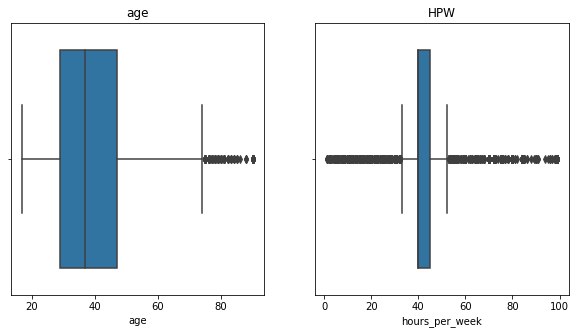

In [100]:
fig = plt.figure(figsize=(10,5))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(X_train['age'])
plt.title('age')

fig.add_subplot(row, col, 2)
sns.boxplot(X_train['hours_per_week'])
plt.title('HPW')

Pada boxplot dilihat bahwa ada outliers pada kolom age dan hours per week

In [101]:
print('X_train skewness =\n',X_train.skew())
print('X_test skewness =\n',X_test.skew())

X_train skewness =
 age               0.502727
education_num    -0.306104
hours_per_week    0.355528
dtype: float64
X_test skewness =
 age               0.514826
education_num    -0.296637
hours_per_week    0.308718
dtype: float64


C:\Users\SBD-HP\AppData\Local\Temp\ipykernel_15232\3996075523.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_train skewness =\n',X_train.skew())
C:\Users\SBD-HP\AppData\Local\Temp\ipykernel_15232\3996075523.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print('X_test skewness =\n',X_test.skew())


dari X train test set didapatkan bahwa sebaran datanya right skewed karena skewness bernilai <0.5

In [102]:
print('Umur Minimum =',X_train['age'].min())
print('Umur Maximum =',X_train['age'].max())
print('Hours Per Week Minimum =',X_train['hours_per_week'].min())
print('Hours Per Week Maximum =',X_train['hours_per_week'].max())

Umur Minimum = 17
Umur Maximum = 90
Hours Per Week Minimum = 1
Hours Per Week Maximum = 99


Pada proc math diatas untuk kolom age minimum termasuk masuk wajar akan tetapi pada nilai maximum tidak wajar. Untuk minimal pada kolom hours_per_week minimum dan maxium termasuk tidak wajar, kemudian untuk data yang tidak wajar outliers perlu di handling

In [103]:
q1age,q2age,q3age = X_train['age'].quantile([0.25, 0.5, 0.75])
q1hpw,q2hpw,q3hpw = X_train['hours_per_week'].quantile([0.25, 0.5, 0.75])

print(X_train['age'].quantile([0.25, 0.5, 0.75]))
print(X_train['hours_per_week'].quantile([0.25, 0.5, 0.75]))

0.25    29.0
0.50    37.0
0.75    47.0
Name: age, dtype: float64
0.25    40.0
0.50    40.0
0.75    45.0
Name: hours_per_week, dtype: float64


Mendapatkan nilai q1,q2,q3

In [104]:
iqrage = q3age-q1age
iqrhpw = q3hpw - q1hpw

minage = q1age - (1.5*iqrage)
maxage = q3age + (1.5*iqrage)
minhpw = q1hpw - (1.5*iqrhpw)
maxhpw = q3hpw + (1.5*iqrhpw)

print("Batas Minimum Outlier X_train Age =", minage)
print("Batas Maximum Outlier X_train Age =", maxage)
print("Batas Minimum Outlier X_train Hours Per Week =", minhpw)
print("Batas Maximum Outlier X_train Hours Per Week =", maxhpw)

Batas Minimum Outlier X_train Age = 2.0
Batas Maximum Outlier X_train Age = 74.0
Batas Minimum Outlier X_train Hours Per Week = 32.5
Batas Maximum Outlier X_train Hours Per Week = 52.5


Proc math batas minimum dan maximum outlier

In [105]:
ix = (X_train[(X_train['age']>maxage) | (X_train['hours_per_week']<minhpw) | (X_train['hours_per_week']>maxhpw)]).index
ix

Int64Index([19756, 22748,  9105, 21822, 16840, 20773, 15003, 14450, 26006,
            14351,
            ...
            27611, 14877, 23560,  2985, 25511, 14808,  5646, 13970, 27528,
            21862],
           dtype='int64', length=5889)

Query untuk handle outlier dengan menyimpan indexnya

In [106]:
X_train.drop(ix,inplace=True) # Filtering data X_train sesuai index hasil query

In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16424 entries, 27766 to 11125
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16424 non-null  int64 
 1   workclass       16424 non-null  object
 2   education_num   16424 non-null  int64 
 3   marital_status  16424 non-null  object
 4   occupation      16424 non-null  object
 5   relationship    16424 non-null  object
 6   race            16424 non-null  object
 7   sex             16424 non-null  object
 8   hours_per_week  16424 non-null  int64 
 9   native_country  16424 non-null  object
dtypes: int64(3), object(7)
memory usage: 1.4+ MB


Setelah handling outlier data X_train berkurang

In [108]:
X_train.reset_index()

,index,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country
0,27766,33,Private,12,Divorced,Adm-clerical,Not-in-family,White,Female,40,United-States
1,1551,55,Self-emp-not-inc,5,Married-civ-spouse,Craft-repair,Husband,White,Male,50,United-States
2,22446,28,Private,8,Never-married,Transport-moving,Not-in-family,White,Male,50,United-States
3,20899,42,Private,13,Divorced,Adm-clerical,Unmarried,White,Male,45,United-States
4,21088,41,State-gov,12,Divorced,Prof-specialty,Unmarried,Asian-Pac-Islander,Female,36,United-States
...,...,...,...,...,...,...,...,...,...,...,...
16419,20971,39,Private,13,Divorced,Sales,Unmarried,White,Female,40,United-States
16420,23030,59,Private,9,Divorced,Exec-managerial,Not-in-family,White,Female,40,United-States
16421,24932,40,Private,9,Divorced,Machine-op-inspct,Not-in-family,Black,Male,40,United-States
16422,22660,70,Private,4,Widowed,Other-service,Not-in-family,White,Female,35,United-States


mereset index dari X_train

c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\SBD-HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'HPW')

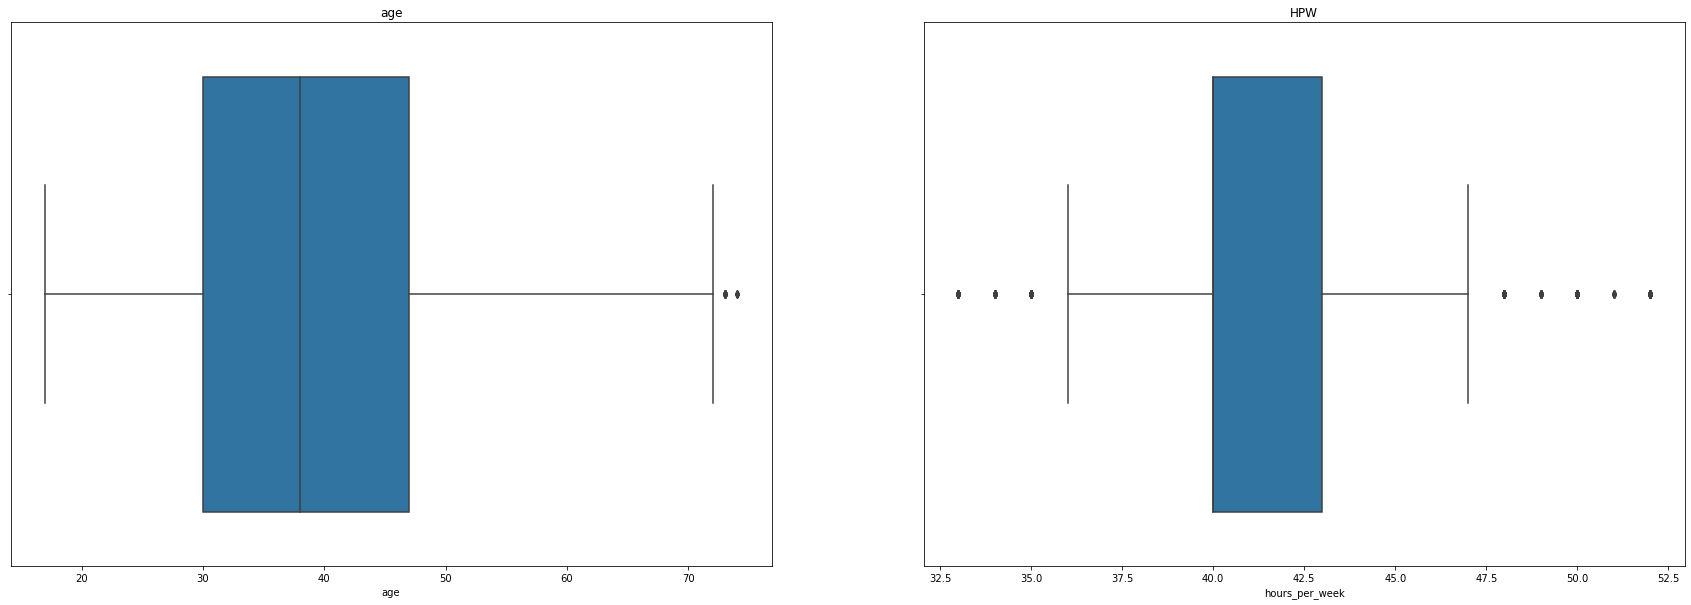

In [109]:
fig = plt.figure(figsize=(30,10))
row = 1
col = 2

# figure, axis = plt.subplots(2,2)
fig.add_subplot(row, col, 1)
sns.boxplot(X_train['age'])
plt.title('age')

fig.add_subplot(row, col, 2)
sns.boxplot(X_train['hours_per_week'])
plt.title('HPW')

Pada boxplot dilihat bahwa ada outliers pada kolom age dan hours per week setelah dihandle sangat berkurang

In [110]:
y_train.drop(ix,inplace=True) # Menyesuaikan row data sesua dengan X_train berdasarkan index row yg di drop tadi

In [111]:
y_train.reset_index() # Reset_index dari y_train

,index,income_bracket
0,27766,<=50K
1,1551,<=50K
2,22446,<=50K
3,20899,>50K
4,21088,<=50K
...,...,...
16419,20971,<=50K
16420,23030,<=50K
16421,24932,<=50K
16422,22660,<=50K


reset_index dari y_train

In [112]:
print('X_train Size =', X_train.shape)
print('X_test Size  =', X_test.shape)
print('y_train Size =', y_train.shape)
print('y_test Size  =', y_test.shape)

X_train Size = (16424, 10)
X_test Size  = (5579, 10)
y_train Size = (16424,)
y_test Size  = (5579,)


Ukuran Nilai dari ke-4 variabel X y train set setelah handling outlier

## Feature Selection

In [113]:
# Get Numerical Columns and Categorical Columns

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', num_columns)
print('Categorical Columns : ', cat_columns)

Numerical Columns :  ['age', 'education_num', 'hours_per_week']
Categorical Columns :  ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


Pemisahan antara kolom numerikal dan kategorikal

In [114]:
# Split Train-Set and Test-Set based on Column Types

X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

Untuk train set juga dipisahkan berdasarkan numerikal dan kategorikal

In [115]:
X_test_cat

,workclass,marital_status,occupation,relationship,race,sex,native_country
9505,Private,Married-civ-spouse,Sales,Husband,White,Male,United-States
19592,Private,Divorced,Exec-managerial,Unmarried,White,Female,United-States
25994,Local-gov,Divorced,Protective-serv,Not-in-family,White,Male,United-States
4623,Self-emp-not-inc,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
12211,Private,Married-civ-spouse,Sales,Husband,White,Male,United-States
...,...,...,...,...,...,...,...
19500,Private,Separated,Machine-op-inspct,Unmarried,Black,Female,United-States
3882,Private,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
13696,State-gov,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
14260,Private,Never-married,Other-service,Own-child,White,Female,United-States


Data diatas adalah salah satu contoh ketika dipisahkan data kategorikal dari X_test menjadi X_test_cat

## Feature Scaling

In [116]:
X_train_num.head() #  5 data awal X_train_num

,age,education_num,hours_per_week
27766,33,12,40
1551,55,5,50
22446,28,8,50
20899,42,13,45
21088,41,12,36


In [117]:
X_train_num.skew() # X_train_num sedikit skewed karena != 0 , maka perlu discaling menggunakan MinMaxScaler

age               0.357108
education_num    -0.344286
hours_per_week    1.010661
dtype: float64

Data X_train_num sedikit skewed karena != 0 , maka perlu discaling menggunakan MinMaxScaler

In [118]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

X_train_num_scaled

array([[0.28070175, 0.73333333, 0.36842105],
       [0.66666667, 0.26666667, 0.89473684],
       [0.19298246, 0.46666667, 0.89473684],
       ...,
       [0.40350877, 0.53333333, 0.36842105],
       [0.92982456, 0.2       , 0.10526316],
       [0.63157895, 0.73333333, 0.36842105]])

Proses scaling dengan fit transfrom untuk X_train_num, dan transform saja untuk X_test_num

In [119]:
print(X_train_num_scaled.shape)
print(X_test_num_scaled.shape)

(16424, 3)
(5579, 3)


Ukuran X_train_num dan X_test_num setelah di scaling

## Feature Encoding

In [120]:
X_train_cat.head() # 5 data awal X_train_cat

,workclass,marital_status,occupation,relationship,race,sex,native_country
27766,Private,Divorced,Adm-clerical,Not-in-family,White,Female,United-States
1551,Self-emp-not-inc,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
22446,Private,Never-married,Transport-moving,Not-in-family,White,Male,United-States
20899,Private,Divorced,Adm-clerical,Unmarried,White,Male,United-States
21088,State-gov,Divorced,Prof-specialty,Unmarried,Asian-Pac-Islander,Female,United-States


In [121]:
# y_train_df = pd.DataFrame(y_train)
# y_test_df = pd.DataFrame(y_test)
# y_train_df

In [122]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns

Syntax untuk mengadaptasi OneHotEncoder untuk langsung memunculkan nama kolom di outputnya.

In [123]:
# Feature Encoding using OrdinalEcoder

encoder = OneHotEncoder()
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_train_cat_encoded.shape

(16424, 83)

Menggunakan OneHotEncoder karena data kategorikal bersifal nominal atau tidak memiliki tingkatan.

In [124]:
X_train_cat_encoded

,workclass_<Federal-gov>,workclass_<Local-gov>,workclass_<Never-worked>,workclass_<Private>,workclass_<Self-emp-inc>,workclass_<Self-emp-not-inc>,workclass_<State-gov>,workclass_<Without-pay>,marital_status_<Divorced>,marital_status_<Married-AF-spouse>,...,native_country_<Portugal>,native_country_<Puerto-Rico>,native_country_<Scotland>,native_country_<South>,native_country_<Taiwan>,native_country_<Thailand>,native_country_<Trinadad&Tobago>,native_country_<United-States>,native_country_<Vietnam>,native_country_<Yugoslavia>
27766,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1551,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22446,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20899,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21088,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20971,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23030,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24932,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22660,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Hasil encoding dari X_train_cat bisa dilihat di atas.

In [125]:
X_test_cat_encoded = encoder.transform(X_test_cat)
X_test_cat_encoded

,workclass_<Federal-gov>,workclass_<Local-gov>,workclass_<Never-worked>,workclass_<Private>,workclass_<Self-emp-inc>,workclass_<Self-emp-not-inc>,workclass_<State-gov>,workclass_<Without-pay>,marital_status_<Divorced>,marital_status_<Married-AF-spouse>,...,native_country_<Portugal>,native_country_<Puerto-Rico>,native_country_<Scotland>,native_country_<South>,native_country_<Taiwan>,native_country_<Thailand>,native_country_<Trinadad&Tobago>,native_country_<United-States>,native_country_<Vietnam>,native_country_<Yugoslavia>
9505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19592,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4623,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12211,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3882,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13696,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14260,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [126]:
le = LabelEncoder()

Fungsi labelencoder untuk data target karena bersifat kategorikal nominal.

In [127]:
y_train_encoded = le.fit_transform(y_train)
y_train_encoded

array([0, 0, 0, ..., 0, 0, 1])

Untuk y_train juga di encoding karena bersifat kategorikal nominal.

In [128]:
y_test_encoded = le.transform(y_test)
y_test_encoded

array([0, 1, 0, ..., 0, 0, 0])

Untuk y_train juga di encoding karena bersifat kategorikal nominal.

In [129]:
# Concate Columns
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)

X_train_final

array([[0.28070175, 0.73333333, 0.36842105, ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.26666667, 0.89473684, ..., 1.        , 0.        ,
        0.        ],
       [0.19298246, 0.46666667, 0.89473684, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.40350877, 0.53333333, 0.36842105, ..., 1.        , 0.        ,
        0.        ],
       [0.92982456, 0.2       , 0.10526316, ..., 1.        , 0.        ,
        0.        ],
       [0.63157895, 0.73333333, 0.36842105, ..., 1.        , 0.        ,
        0.        ]])

Penggabungan data final dari data yang telah di scaling dan encoding

In [130]:
print('X_train Size =', X_train_final.shape)
print('X_test Size  =', X_test_final.shape)
print('y_train Size =', y_train_encoded.shape)
print('y_test Size  =', y_test_encoded.shape)

X_train Size = (16424, 86)
X_test Size  = (5579, 86)
y_train Size = (16424,)
y_test Size  = (5579,)


Ukuran dari data X y Train test final

---
# 6. Model definition

### Logistic Regression

In [131]:
model_log_reg = LogisticRegression()

Pengdefinisial model logistik regresi

---
# 7. Model Training

In [132]:
# Train model menggunakan dataset X dan y train
model_log_reg.fit(X_train_final, y_train_encoded)

c:\Users\SBD-HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Melakukan fit logisticregression untuk X_train_final dan y_train_encoded

---
# 8.    Model Evaluation

In [133]:
#Predict testing set
y_pred = model_log_reg.predict(X_test_final)
y_pred

array([1, 0, 0, ..., 0, 0, 0])

Prediksi berdasarkan model regresi logistik

In [134]:
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4167
           1       0.66      0.62      0.64      1412

    accuracy                           0.82      5579
   macro avg       0.76      0.75      0.76      5579
weighted avg       0.82      0.82      0.82      5579



Hasil classification report bisa terlihat untuk akurasi sebesar 82%

In [135]:
roc_auc_score(y_test_encoded, y_pred)

0.75371213928948

Score ROC AUC Score tidak terlalu bagus

## Hyperparameter Tuning

In [136]:
#define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
cval    = [1, 10, 100]

#define grid
grid = dict(solver=solvers,penalty=penalty,C=cval)

Mencoba mencari hyperparameter terbaik dengan beberapa parameter yang akan dicoba sesuai cell diatas.

In [137]:
grid_search = GridSearchCV(estimator=model_log_reg, param_grid=grid, n_jobs=-1, cv=3, scoring='accuracy',error_score=0,return_train_score=True)

Pencarian hyperparameter terbaik menggunakan GridSearchCV

In [138]:
best_model = grid_search.fit(X_train_final, y_train_encoded)

c:\Users\SBD-HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\SBD-HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\SBD-HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\SBD-HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

Melakukan fit kembali dengan hyperparameter terbaik dari yang telah dicari sebelumnya dengan GridSearchCV

## Logistic Regression Evaluation

In [139]:
#Nilai hyperpaameters terbaik
print("Test set score: {:.2f}".format(grid_search.score(X_test_final, y_test_encoded)))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Test set score: 0.82
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.81
Best estimator:
LogisticRegression(C=1, penalty='l1', solver='liblinear')


'C': 1, 'penalty': 'l2', 'solver': 'lbfgs' ini merupakan hyperparameter terbaik hasil dari GridSearchCV

In [140]:
y_pred2 = best_model.predict(X_test_final)

Mencoba prediksi kedua di model regresi logistik dengan hyperparameter terbaik

In [141]:
print(classification_report(y_test_encoded, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4167
           1       0.66      0.61      0.63      1412

    accuracy                           0.82      5579
   macro avg       0.76      0.75      0.76      5579
weighted avg       0.82      0.82      0.82      5579



Berdasarkan classification report nampak tidak ada perubahan dari score accuracy

In [142]:
y_pred2= best_model.predict(X_test_final)
roc_auc_score(y_test_encoded, y_pred2)

0.7515933569507074

Nilai dari ROC AUC nya pun sama dengan sebelumnya.
Diasumsikan model perubahan hyperparameter tidak memberikan perbedaan dalam akurasi.

----

## SVM

---

In [143]:
svm = SVC(kernel='rbf',gamma=1,C=1)
svm.fit(X_train_final, y_train_encoded)

SVC(C=1, gamma=1)

Pendefinisian model SVM dengan menggunakan hyperparameter kernel rbf, gamma = 1, dan C=1

In [144]:
y_predsvm = svm.predict(X_test_final)

Melakukan prediksi dengan model svm

In [145]:
print(classification_report(y_test_encoded, y_predsvm))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4167
           1       0.68      0.55      0.61      1412

    accuracy                           0.82      5579
   macro avg       0.77      0.73      0.75      5579
weighted avg       0.81      0.82      0.81      5579



Berdasarkan classification report akurasi model tersebut sebar 82%.

In [146]:
# Predict Train-Set and Test-Set
y_logpred_train = best_model.predict(X_train_final)
y_logpred_test = best_model.predict(X_test_final)

y_svmpred_train = svm.predict(X_train_final)
y_svmpred_test = svm.predict(X_test_final)


Untuk rangkuman, mencoba melakukan prediksi ulang dengan 2 model yang telah dibuat.

In [147]:
print('Log Reg Accuracy Score Train :', accuracy_score(y_train_encoded,y_logpred_train))
print('log Reg Accuracy Score Test :', accuracy_score(y_test_encoded,y_logpred_test))
print('')
print('SVM Accuracy Score Train :', accuracy_score(y_train_encoded,y_svmpred_train))
print('SVM Accuracy Score Test :', accuracy_score(y_test_encoded,y_svmpred_test))

Log Reg Accuracy Score Train : 0.8146614710180224
log Reg Accuracy Score Test : 0.820577164366374

SVM Accuracy Score Train : 0.8348757915245981
SVM Accuracy Score Test : 0.8212941387345403


Berikut adalah score dari masing-masing model train dan test.

Untuk Regresi Logistik dengan nilai skor yang cukup konsisten bisa diasumsikan model tersebut good fit dalam melakukan prediksi.

Untuk SVM nilai skor test lebih rendah sekitar 1% dari Train, bisa diasumsikan modelnya overfitting dalam melakukan prediksi

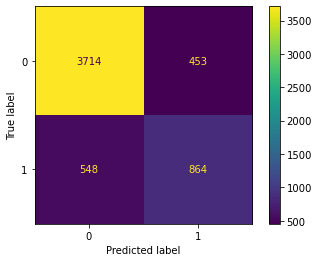

In [149]:
cm = confusion_matrix(y_test_encoded,y_logpred_test, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)

disp.plot()
plt.show()

Confusion Matrix X_test. Nilai 3714 adalah banyaknya data hasil prediksi golongan pendapatan yang masuk kategori >=50k dan kenyataan pada data observasi sesungguhnya golongan pendapatan tersebut merupakan kategori benar. Nilai 453 adalah banyaknya data hasil prediksi golongan pendapatan yang masuk kategori >=50k tapi kenyataan pada data observasi sesungguhnya nilai tersebut merupakan kategori salah tetapi terdeteksi benar. Nilai 548 adalah banyaknya data hasil prediksi golongan pendapatan yang masuk kategori >50k tapi kenyataan pada data observasi sesungguhnya nilai tersebut merupakan kategori benar tetapi terdeteksi salah. Nilai 864 adalah banyaknya data hasil prediksi golongan pendapatan yang masuk kategori >50k dan kenyataan pada data observasi sesungguhnya nilai tersebut merupakan kategori benar salah.

---
# 9.    Model Saving

In [ ]:
# Model Saving

import pickle

with open('model_scaler.pkl', 'wb') as file_1:
  pickle.dump(scaler, file_1)

with open('model_encoder.pkl', 'wb') as file_2:
  pickle.dump(encoder, file_2)

with open('model_log_reg.pkl', 'wb') as file_3:
  pickle.dump(best_model, file_3)

with open('model_svm.pkl', 'wb') as file_6:
  pickle.dump(svm, file_6)

with open('list_num_columns.txt', 'w') as file_4:
  file_4.write(str(num_columns))

with open('list_cat_columns.txt', 'w') as file_5:
  file_5.write(str(cat_columns))

Penyimpanan model-model yang telah dibuat ke dalam pickle

Menyimpan model yang telah dibuat

---
# 10.   Load Model

In [ ]:
# Load All Files

with open('model_scaler.pkl', 'rb') as file_1:
  model_scaler = pickle.load(file_1)

with open('model_encoder.pkl', 'rb') as file_2:
  model_encoder = pickle.load(file_2)

with open('model_log_reg.pkl', 'rb') as file_3:
  model_log_reg = pickle.load(file_3)

with open('list_num_columns.txt', 'r') as file_4:
  list_num_columns = file_4.read()

with open('list_cat_columns.txt', 'r') as file_5:
  list_cat_columns = file_5.read()

with open('model_svm.pkl', 'rb') as file_6:
  model_svm = pickle.load(file_6)

In [ ]:
Load model yang telah dibuat.

In [ ]:
# Convert `num_columns` and `cat_columns` into List

import ast

list_num_columns = ast.literal_eval(list_num_columns)
list_cat_columns = ast.literal_eval(list_cat_columns)
list_num_columns

['age', 'education_num', 'hours_per_week']

## Inferencing

Lakukan test terhadap data inference (data yang akan ada di masa depan). Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

In [ ]:
# Split between Numerical Columns and Categorical Columns

df_inf_num = df_inf[list_num_columns]
df_inf_cat = df_inf[list_cat_columns]

df_inf_num

,age,education_num,hours_per_week
0,43,9,45
1,54,9,40
2,38,13,56
3,36,10,35
4,18,6,40
5,25,9,45
6,46,9,40
7,55,9,60
8,39,10,40
9,44,10,57


Split data numerik dan kategorik pada data yang akan diprediksi

In [ ]:
# Feature Scaling and Feature Encoding

df_inf_num_scaled = model_scaler.transform(df_inf_num)
df_inf_cat_encoded = model_encoder.transform(df_inf_cat)
df_inf_num_scaled

array([[0.45614035, 0.53333333, 0.63157895],
       [0.64912281, 0.53333333, 0.36842105],
       [0.36842105, 0.8       , 1.21052632],
       [0.33333333, 0.6       , 0.10526316],
       [0.01754386, 0.33333333, 0.36842105],
       [0.14035088, 0.53333333, 0.63157895],
       [0.50877193, 0.53333333, 0.36842105],
       [0.66666667, 0.53333333, 1.42105263],
       [0.38596491, 0.6       , 0.36842105],
       [0.47368421, 0.6       , 1.26315789]])

Dilakukan scaling pada data numerik dan encoding untuk data kategorik.

In [ ]:
# Concate Numerical Columns and Categorical Columns

df_inf_final = np.concatenate([df_inf_num_scaled, df_inf_cat_encoded], axis=1)
df_inf_final

array([[0.45614035, 0.53333333, 0.63157895, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

Digabungkan kembali menjadi 1 matriks.

In [ ]:
# Predict Inference-Set

y_pred_inf = model_log_reg.predict(df_inf_final)
y_pred_inf

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

Menggunakan model logistic regression, dilakukan income_bracket prediction dari df_inf tadi.

In [ ]:
# Convert into DataFrame

y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Income_Bracket Prediction'])
y_pred_inf_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Income_Bracket Prediction  10 non-null     int32
dtypes: int32(1)
memory usage: 168.0 bytes


Berikut hasil prediksi berdasarkan model yang telah dibuat.

In [ ]:
# Merge Inference-Set and Prediction

pd.concat([df_inf, y_pred_inf_df], axis=1)

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,income_bracket,Income_Bracket Prediction
0,43,Private,9,Separated,Handlers-cleaners,Unmarried,Black,Female,45,United-States,<=50K,0
1,54,Private,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,United-States,<=50K,0
2,38,Private,13,Divorced,Prof-specialty,Unmarried,White,Female,56,United-States,<=50K,0
3,36,Private,10,Married-civ-spouse,Exec-managerial,Wife,White,Female,35,United-States,>50K,1
4,18,Private,6,Never-married,Machine-op-inspct,Own-child,White,Male,40,United-States,<=50K,0
5,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,45,United-States,<=50K,0
6,46,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K,0
7,55,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,60,United-States,<=50K,1
8,39,Private,10,Married-spouse-absent,Craft-repair,Unmarried,White,Male,40,United-States,>50K,0
9,44,Private,10,Divorced,Adm-clerical,Unmarried,White,Female,57,United-States,<=50K,0


0 = <=50K dan 1 = >50K

---
# 11.   Kesimpulan

Dari proses EDA ditemukan beberapa hal

-   Untuk Regresi Logistik dengan nilai train ternyata lebih rendah 1 % dari test bisa diasumsikan model tersebut good fit dalam melakukan prediksi.
-   Untuk SVM nilai skor test lebih rendah sekitar 1% dari Train, bisa diasumsikan modelnya overfit dalam melakukan prediksi
-   Terjadi kelemahan prediksi pada kategori 1 yang dikarenakan data imbalance terhadap data terkecil pada kategori ini. Sehingga model belum banyak belajar mengenai kategori ini dan meningkatkan misspredict.
-   Kedua model memiliki jumlah kesalahan prediksi 2 data. Sehingga bisa dikatakan bahwa performa kedua model mirip, namun ada baiknya dilakukan test dengan data yang lebih banyak sebelum dibandingkan kembali.
-   Mengenai hubungan antara variabel golongan pendapatan(terget/y) yang jenis data berbentuk kategorik yaitu pendapatan >=50k dan >50k, terhadap variabel (fitur/X) berupa usia, kelas kerja, nomor pendidikan, pendidikan, perkerjaan dan jenis kelamin. Dalam Kasus ini, dilakukan pendekatan analisis menggunakan Exploratory Data Analysis (EDA), Logistic Regression dan Support Vector Machine.
- Log Reg Accuracy Score Train : 0.8146614710180224
- Log Reg Accuracy Score Test : 0.820577164366374
- SVM Accuracy Score Train : 0.8348757915245981
- SVM Accuracy Score Test : 0.8212941387345403

Untuk pengembangan selanjutnya, memperbaiki model untuk meningkatkan nilai Accuracy Score Train dan Accuracy Score Test dengan:

-   Menambah atau mengurangi feature
-   Mengganti modelnya dengan model lain.
-   Mengganti parameter SVC/LogReg
-   Melakukan handling data imbalance

---
# 12.   Conceptual Problems

Jawab pertanyaan berikut:

-   Apakah yang dimaksud dengan coeficient pada logistic regression?
> Koefisien di regresi menyatakan hubungan searah atau berbalik arah antara variabel independen dan variabel dependen

-   Apakah yang dimaksud dengan Support Vector pada SVM?
> Support Vector Machine merupakan salah satu metode dalam supervised learning yang biasanya digunakan untuk klasifikasi (Support Vector Classification) dan regresi (Support Vector Regression). SVM digunakan untuk mencari hyperplane terbaik dengan memaksimalkan jarak antar kelas dari kumpulan data. Hyperplane sebagai garis fungsi yang digunakan untuk pemisah antar kelas. Dalam SVM objek data terluar yang paling dekat dengan hyperplane merupakan support vector. Jadi support vektor sebagai batas akhir dari objek sebuah kelas yang membatasi antara kelas data terluar.

-   Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!
>  Metode untuk memetakan data non-linear. Kernel pada SVM sebagai metode yang dipakai untuk memetakan data non-linear berdimensi rendah dan mengubahnya ke dalam ruang dimensi yang lebih tinggi. Tujuannya untuk memudahkan pengklasifikasian data dengan menemukan hyperplane yang dapat memisahkan dataset secara linear dengan baik. Salah satu kernal yang saya gunakan pada kasus ini adalah RBF, dimana kernal rbf salah satu jenis kernal untuk memecahkan masalah klasifikasi data yang tidak dapat dipisahkan secara linear, dimana akan menghasilkan nilai error yang kecil dibandingkan dengan kernel lainnya.